# Rusty Bargain

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

Características:

- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo

Objetivo

- Price — precio (en euros)

## Preparación de datos

## 1. Librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

## 2. Cargar datos

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

#Tipo de datos y columnas del dataframe
df.info()
print('')
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

## 3. Limpieza de datos

In [3]:
#Valores nulos
dfx = df.isna().sum()
dfx = dfx[dfx>0]
dfx = pd.DataFrame(dfx, columns=['Valores_nulos'])
dfx['pct_total'] = dfx['Valores_nulos']/len(df)
print('')
print(dfx)


             Valores_nulos  pct_total
VehicleType          37490   0.105794
Gearbox              19833   0.055967
Model                19705   0.055606
FuelType             32895   0.092827
NotRepaired          71154   0.200791


Se observan datos ausentes en las columnas VehicleType, Gearbox, Model, FuelType y NotRepaired. Estos datos se completarán creando una nueva categoría "Unknown" ya que son columnas importantes para definir el precio de un vehículo y por lo que no se pueden eliminar.

In [4]:
#Procesamiento de valores nulos
df = df.fillna('Unknown')
print(df.isnull().sum())

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


In [5]:
#Eliminar columnas irrelevantes
df = df.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [6]:
#estadísticas descriptivas
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


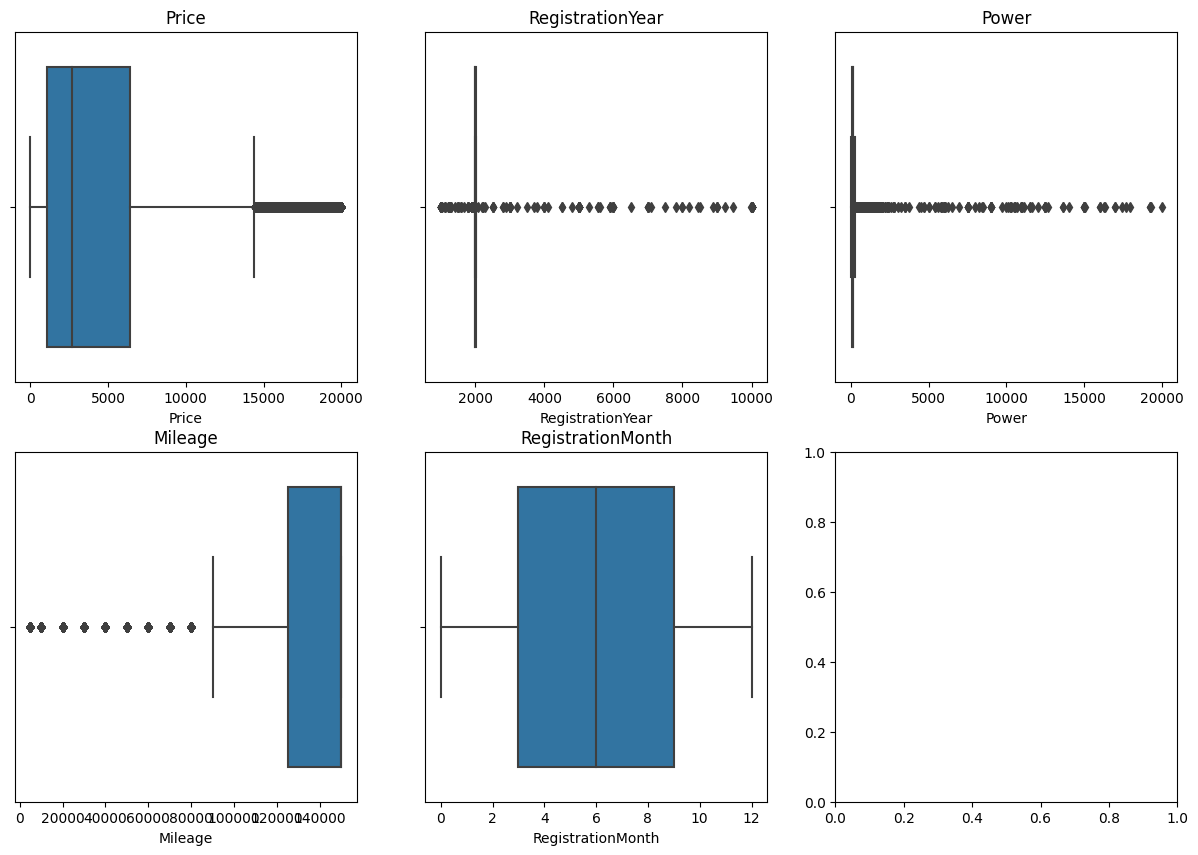

In [7]:
# Boxplots para analizar posibles valores atípicos
cols = ['Price','RegistrationYear','Power','Mileage','RegistrationMonth']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
col_index = 0

for row in axes:
    for ax in row:
        if col_index < len(cols):
            col_name = cols[col_index]
            sns.boxplot(df[col_name], ax=ax)
            ax.set_title(f'{col_name}')

            col_index += 1   
              

Se pueden observar valores atípicos en las columnas Price, RegistrationYear, Power y Mileage. Los valores atípicos de Price y Mileage pueden deberse a mejores autos. Sin embargo, los valores de RegistrationYear y Power deben filtrarse para quedarse únicamente con registros validos.

In [8]:
#Depurar datos atípicos
##Filtrar RegistrationYear
df = df[(df['RegistrationYear'] >= 1950) & (df['RegistrationYear'] <= 2025)]

#Filtrar Power
df = df[(df['Power'] >= 10) & (df['Power'] <= 500)]

## 4. Preparar datos

In [9]:
#Separar features y target
X = df.drop('Price', axis=1)
y = df['Price']

#Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

#Variables categóricas y numéricas
categorical_cols = X.select_dtypes('object').columns
numeric_cols = X.select_dtypes('int64').columns

#StandardScaler y one hot encoding
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numeric_cols), 
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

Se realizó la división de datos en los grupos train y test. Por otra parte, se generó un preprocesador para estandarizar las columnas numéricas y aplicar OHE a las columnas categóricas para los modelos que lo requieran.

## Entrenamiento del modelo 

## 1. Regresión lineal

In [10]:
#Entrenar modelo
lr_pipeline = Pipeline(steps=[('preprocess', preprocessor),
                             ('regressor', LinearRegression())])

inicio = time()
lr_pipeline.fit(X_train, y_train)
fin_fit_lr = time() - inicio

inicio_pred =time()
y_pred = lr_pipeline.predict(X_test)
fin_pred_lr = time() - inicio_pred

#Evaluación del modelo con RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE Regresión Lineal:', rmse_lr)

print('Tiempo entranamiento Regresión lineal:', fin_fit_lr)
print('Tiempo predicción Regresión lineal:', fin_pred_lr)

RMSE Regresión Lineal: 2646.714286718587
Tiempo entranamiento Regresión lineal: 12.993515253067017
Tiempo predicción Regresión lineal: 0.16614913940429688


## 2. Árbol de decisión

In [11]:
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', DecisionTreeRegressor(random_state=12345))])

#Optimizar hiperparámetros
param_grid = {'regressor__max_depth': [5, 15],
             'regressor__min_samples_leaf': [1, 10]}

grid_tree = GridSearchCV(dt_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error',  n_jobs=-1, verbose=1)

#Entrenar el modelo
inicio = time()
grid_tree.fit(X_train, y_train)
print("Mejores parámetros:", grid_tree.best_params_)
fin_fit_dt = time() - inicio

inicio_pred =time()
y_pred = grid_tree.predict(X_test)
fin_pred_dt = time() - inicio_pred

#Evaluación del modelo con RMSE
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE Decision Tree:', rmse_dt)
print('Tiempo entranamiento Decision Tree:', fin_fit_dt)
print('Tiempo predicción Decision Tree:', fin_pred_dt)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros: {'regressor__max_depth': 15, 'regressor__min_samples_leaf': 10}
RMSE Decision Tree: 1914.4037481838839
Tiempo entranamiento Decision Tree: 30.51494336128235
Tiempo predicción Decision Tree: 0.0983734130859375


## 3. Random Forest

In [12]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', RandomForestRegressor(random_state=12345))])

#Optimizar parámetros
param_grid ={'regressor__n_estimators': [50],
    'regressor__max_depth': [5, 10],
    'regressor__min_samples_leaf': [5, 10]}

grid_rf = GridSearchCV(rf_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error',  n_jobs=-1, verbose=1)

#Entrenar el modelo
inicio= time()
grid_rf.fit(X_train, y_train)
print("Mejores parámetros:", grid_rf.best_params_)
fin_fit_rf = time() - inicio

inicio_pred =time()
y_pred = grid_rf.predict(X_test)
fin_pred_rf = time() - inicio_pred

#Evaluación del modelo con RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE RandomForest:', rmse_rf)
print('Tiempo Entrenamiento RandomForest:', fin_fit_rf)
print('Tiempo predicción RandomForest:', fin_pred_rf)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 5, 'regressor__n_estimators': 50}
RMSE RandomForest: 1982.059198387921
Tiempo Entrenamiento RandomForest: 430.0952434539795
Tiempo predicción RandomForest: 0.3325202465057373


## 4. LightGBM

In [13]:
# Convertir columnas categóricas a tipo category
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

for col in categorical_cols:
    X_train_lgbm[col] = X_train_lgbm[col].astype('category')
    X_test_lgbm[col] = X_test_lgbm[col].astype('category')


#Optimizar hiperparámetros
param_grid_lgbm = {'n_estimators': [100, 200],
    'max_depth': [10, 15],
    'learning_rate': [0.05, 0.1]}

lgbm_model = LGBMRegressor(random_state=12345)

grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

#Entrenar el modelo
inicio = time()
grid_lgbm.fit(X_train_lgbm, y_train)
print("Mejores parámetros:", grid_rf.best_params_)
fin_fit_lgbm = time() - inicio

inicio_pred =time()
y_pred = grid_lgbm.predict(X_test_lgbm)
fin_pred_lgbm = time() - inicio_pred

#Evaluación del modelo con RMSE
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE LightGBM:', rmse_lgbm)
print('Tiempo Entrenamiento LightGBM:', fin_fit_lgbm)
print('Tiempo predicción LightGBM:', fin_pred_lgbm)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores parámetros: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 5, 'regressor__n_estimators': 50}
RMSE LightGBM: 1692.7622761730759
Tiempo Entrenamiento LightGBM: 31.258216381072998
Tiempo predicción LightGBM: 0.6225769519805908


## 5. CatBoost

In [14]:
# Convertir columnas categóricas a tipo category
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

for col in categorical_cols:
    X_train_cb[col] = X_train_cb[col].astype('category')
    X_test_cb[col] = X_test_cb[col].astype('category')

cat_features = list(X_train_cb.select_dtypes('category').columns)

#Optimizar hiperparámetros    
param_grid_cb = {'n_estimators': [100],
    'depth': [6, 10],
    'learning_rate': [0.05, 0.1]}

cb_model = CatBoostRegressor(random_state=12345, verbose=0)

grid_cb = GridSearchCV(cb_model, param_grid_cb, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

#Entrenar modelo
inicio = time()
grid_cb.fit(X_train_cb, y_train, cat_features=cat_features)

print("Mejores parámetros:", grid_cb.best_params_)
fin_fit_cb = time() - inicio

inicio_pred =time()
y_pred = grid_cb.predict(X_test_cb)
fin_pred_cb = time() - inicio_pred

#Evaluación del modelo con RMSE
rmse_cb = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE CatBoost:', rmse_cb)
print('Tiempo Entrenamiento CatBoost:', fin_fit_cb)
print('Tiempo predicción CatBoost:', fin_pred_cb)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Mejores parámetros: {'depth': 10, 'learning_rate': 0.1, 'n_estimators': 100}
RMSE CatBoost: 1773.9901358975974
Tiempo Entrenamiento CatBoost: 53.22817516326904
Tiempo predicción CatBoost: 0.04707503318786621


## 6. XGBoost

In [15]:
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', XGBRegressor(random_state=12345))])

param_grid_xgb = {'regressor__n_estimators': [20, 60],
    'regressor__max_depth': [2, 6],
    'regressor__learning_rate': [0.05, 0.1]}

grid_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)

#Entrenar modelo
inicio = time()
grid_xgb.fit(X_train, y_train)

print("Mejores parámetros:", grid_xgb.best_params_)
fin_fit_xgb = time() - inicio

inicio_pred =time()
y_pred = grid_xgb.predict(X_test)
fin_pred_xgb = time() - inicio_pred

#Evaluación del modelo con RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE XGBoost:', rmse_xgb)
print('Tiempo Entrenamiento XGBoost:', fin_fit_xgb)
print('Tiempo predicción XGBoost:', fin_pred_xgb)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Mejores parámetros: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 60}
RMSE XGBoost: 1841.6182810349858
Tiempo Entrenamiento XGBoost: 629.8063097000122
Tiempo predicción XGBoost: 0.19740700721740723


## Análisis del modelo

In [16]:
#Comparación de resultados

df_all = pd.DataFrame({'Modelo': ['Regresion lineal', 'Arbol de decisión', 'Random Forest', 'LightGBM', 'CatBoost', 'XGBoost'],
                       'RMSE':[rmse_lr, rmse_dt, rmse_rf, rmse_lgbm, rmse_cb, rmse_xgb],
                      'Tiempo de entrenamiento': [fin_fit_lr, fin_fit_dt, fin_fit_rf, fin_fit_lgbm, fin_fit_cb, fin_fit_xgb],
                      'Tiempo de predicción': [fin_pred_lr, fin_pred_dt, fin_pred_rf, fin_pred_lgbm, fin_pred_cb, fin_pred_xgb]})

print(df_all)

              Modelo         RMSE  Tiempo de entrenamiento  \
0   Regresion lineal  2646.714287                12.993515   
1  Arbol de decisión  1914.403748                30.514943   
2      Random Forest  1982.059198               430.095243   
3           LightGBM  1692.762276                31.258216   
4           CatBoost  1773.990136                53.228175   
5            XGBoost  1841.618281               629.806310   

   Tiempo de predicción  
0              0.166149  
1              0.098373  
2              0.332520  
3              0.622577  
4              0.047075  
5              0.197407  


## Conclusiones

- Es evidente que la prueba de cordura con la regresión lineal funcionó correctamente ya que todos los demás modelos superaron su rendimiento.
- El modelo con mayor precisión corresponde al LightGBM que presenta el menor RMSE y tiene el menor tiempo de entrenamiento despues de la regresión lineal. Si bien tiene el tiempo más lento entre los modelos de potenciación de gradiente, sigue siendo un tiempo relativamente aceptable para una app.
- Una segunda opción podría ser el modelo CatBoost que presenta el segundo mejor RMSE y el menor tiempo de predicción.